#### 匯入函式庫

In [27]:
#匯入函式庫，數值矩陣計算numpy，以及畫圖用的matplotlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#匯入
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf

In [94]:
#文件搜索的工具
import glob

#這是一個看迴圈進度條的小工具
from tqdm import tqdm 

#匯入電腦視覺的函式庫，作影像讀取和分析使用
import cv2


mpl.rcParams['figure.figsize'] = (10,10) #畫布尺寸

### 定義測試資料

In [4]:
#欲分類的lable與數量
labels_name = ['NORMAL', 'PNEUMONIA']
num_classes = len(labels_name)


In [5]:
#建立訓練資料所在的路徑位置與對應的label：(filelist, label)
#label為數字，0代表'NORMAL'、1代表'PNEUMONIA'
filelist = []
label = []
for i in labels_name:
    class_num = labels_name.index(i)
    pathfile = glob.glob('chest_xray/test/'+str(i)+'/*.jpeg')
    
    for p in pathfile:
        filelist.append(p)
        label.append(class_num)

In [6]:
#影像縮放大小
desired_size = 256

In [7]:
#定義一個縮放影像(img)至指定大小(desired_size)的函數
#等比例縮小，其他地方補黑邊
def squared(img, desired_size):
    old_size = img.shape[:2]
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_img

### 開始讀入影像

In [9]:
#先宣告一個指定大小的ndarray
x_test = np.zeros((len(filelist),desired_size,desired_size,3), dtype=np.float32)

In [11]:
#開始讀入影像
for i in tqdm(range(len(filelist))):
    img = cv2.imread(filelist[i],cv2.IMREAD_GRAYSCALE)
    new_img = squared(img, desired_size)

#進行正規化(normalization)，常用除255或z-score
    m = np.mean(new_img)
    s = np.std(new_img)
    t = (new_img-m)/s
#    t=new_img/255

#三個channel可給予不同的處理手法
    x_test[i,:,:,0]=t
    x_test[i,:,:,1]=t
    x_test[i,:,:,2]=t

100%|██████████| 624/624 [00:04<00:00, 151.75it/s]


### 模型匯入與切分資料集

In [12]:
#撰寫模型的路徑
model_name = 'x_ray'
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_path = os.path.join(save_dir, model_name)

In [13]:
#載入訓練好的模型
model = tf.keras.models.load_model(model_path)

### 預測結果

In [14]:
#使用AI模型作預測
pred=model.predict(x_test)

In [15]:
#將預測的機率轉換成類別
ans=np.argmax(pred, axis=-1)

## GradCAM

In [17]:
#定義計算gradcam的heatmap
#該函數參考官網https://keras.io/examples/vision/grad_cam/

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

## 抓一筆影像測試

In [95]:
k=26

#抓取原影像
img = cv2.imread(filelist[k],cv2.IMREAD_GRAYSCALE)
img = squared(img, desired_size)

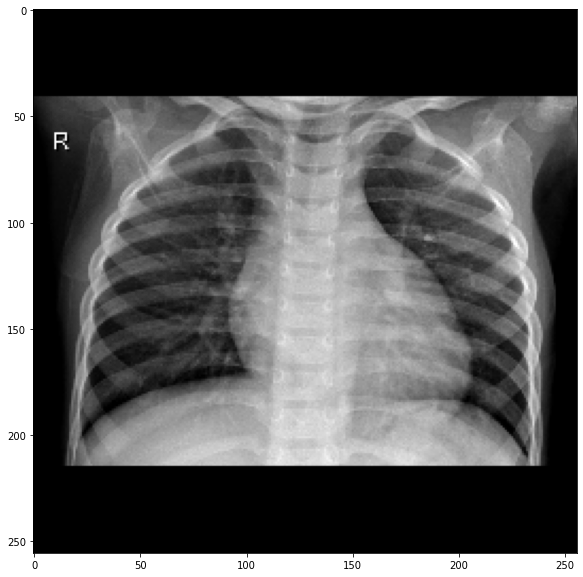

In [98]:
plt.imshow(img,cmap='gray')

#test資料有作過z-score，畫圖不適合
#plt.imshow(x_test[k])

In [100]:
#model.summary()

In [89]:
#要看哪個Layer，請參考model
last_conv_layer_name = "conv5_block3_1_conv"

In [102]:
#input在餵進去時記得多加一個維度for batch
img_array = np.expand_dims(x_test[k], axis=0)
#作預測
pred = model.predict(img_array)
print("Predicted:", np.argmax(pred))

Predicted: 1


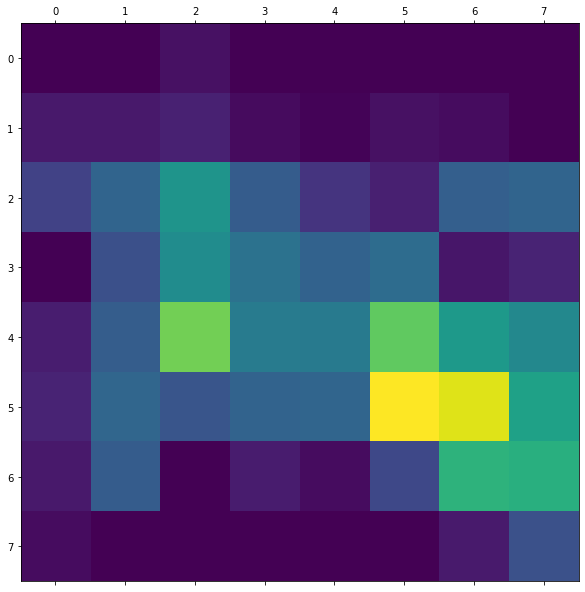

In [103]:
#算heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

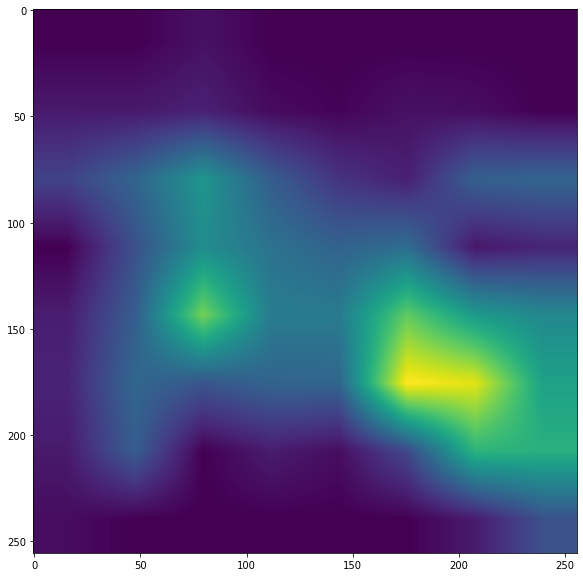

In [105]:
#resize後比較好看
heatmap_resize = cv2.resize(heatmap,(256,256))
plt.imshow(heatmap_resize)

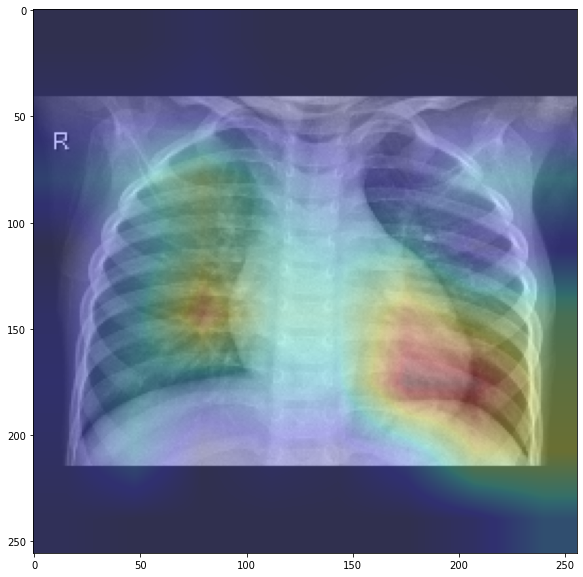

In [107]:
#最後來疊在一起
fig, ax = plt.subplots()  

# 以 0.75 透明度繪製原始影像
ax.imshow(img, cmap='gray',alpha=0.75) 

# 以 0.25 透明度繪製熱力圖
ax.imshow(heatmap_resize, cmap='jet', alpha=0.25)

plt.show()